In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
# 加载数据
datafilename1 = "C:\\Users\\Administrator\\Desktop\\MFEG\\dataprocessing\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']



In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size, strides):
    shortcut = x
    # 主卷积路径
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果shortcut的形状与x不匹配，则调整shortcut
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # 添加跳过连接
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1=x
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x1=Conv1D(64, 3, strides=4, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x+=x1
    x2=x
    x = residual_block(x, 128,3, 2)
    x = residual_block(x, 256,3, 2)
    x2=Conv1D(256, 3, strides=4, padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x+=x2
    # Classifier
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Example usage:
model =resnet((4500, 1), 4)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=256, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
55/55 [==============================] - 20s 128ms/step - loss: 0.4132 - accuracy: 0.5877 - val_loss: 0.4214 - val_accuracy: 0.5537
Epoch 2/80
55/55 [==============================] - 5s 93ms/step - loss: 0.3721 - accuracy: 0.6403 - val_loss: 0.3924 - val_accuracy: 0.6294
Epoch 3/80
55/55 [==============================] - 5s 93ms/step - loss: 0.3224 - accuracy: 0.7027 - val_loss: 0.3414 - val_accuracy: 0.6872
Epoch 4/80
55/55 [==============================] - 5s 93ms/step - loss: 0.2807 - accuracy: 0.7547 - val_loss: 0.2858 - val_accuracy: 0.7477
Epoch 5/80
55/55 [==============================] - 5s 93ms/step - loss: 0.2440 - accuracy: 0.7957 - val_loss: 0.2548 - val_accuracy: 0.7798
Epoch 6/80
55/55 [==============================] - 5s 93ms/step - loss: 0.2221 - accuracy: 0.8200 - val_loss: 0.2278 - val_accuracy: 0.8082
Epoch 7/80
55/55 [==============================] - 5s 94ms/step - loss: 0.1931 - accuracy: 0.8495 - val_loss: 0.2226 - val_accuracy: 0.8104
Epoch 8/80


In [7]:
evaluate_model(model,X_test,y_test)

Precision: 0.8809354258768212
Recall: 0.8268455967613264
F1 Score: 0.8465176177014646
Accuracy: 0.8644408688656476
Class 1 - Precision: 0.8274509803921568, Recall: 0.9295154185022027, F1 Score: 0.87551867219917
Class 2 - Precision: 0.9053691275167786, Recall: 0.8987341772151899, F1 Score: 0.9020394516883985
Class 3 - Precision: 0.7909215955983494, Recall: 0.7791327913279132, F1 Score: 0.7849829351535836
Class 4 - Precision: 1.0, Recall: 0.7, F1 Score: 0.8235294117647058
Class 1 Accuracy: 0.9758648431214803
Class 2 Accuracy: 0.8821399839098955
Class 3 Accuracy: 0.8732904263877715
Class 4 Accuracy: 0.997586484312148


In [8]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

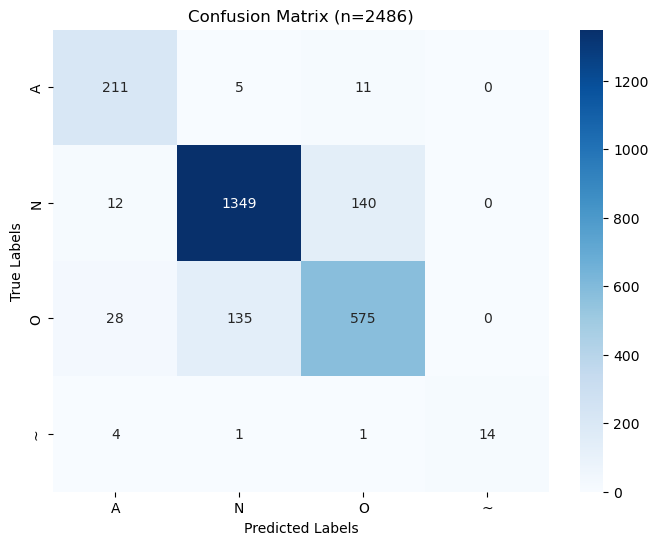

In [9]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])